In [2]:
import pandas as pd, numpy as np, os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json


In [3]:
csv_path = "../data/parkinsons.data.txt"   # make sure file is inside /data/
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (195, 24)
Columns: ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
# Cell: prepare X, y
# set target name if different
TARGET = 'status'
# drop non-numeric columns (like 'name' if present)
X = df.select_dtypes(include=[np.number]).drop(columns=[TARGET], errors='ignore')
y = df[TARGET].copy()

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())
X.head()


X shape: (195, 22)
y distribution:
 status
1    147
0     48
Name: count, dtype: int64


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (156, 22) Test: (39, 22)


In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
k = min(10, X_train.shape[1])   # start with top 10 (adjust if fewer features)
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)

# scores and chosen features
scores = pd.Series(selector.scores_, index=X_train.columns).sort_values(ascending=False)
print("Feature scores (top {}):".format(k))
display(scores.head(k))

selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask].tolist()
print("Selected features:", selected_features)

# Reduced datasets
X_train_sel = X_train[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()


Feature scores (top 10):


spread1             74.749448
PPE                 61.188517
spread2             31.891507
HNR                 29.694514
MDVP:Shimmer        27.043151
MDVP:APQ            25.886143
MDVP:Flo(Hz)        24.915637
Shimmer:APQ5        24.883158
D2                  24.743275
MDVP:Shimmer(dB)    24.268531
dtype: float64

Selected features: ['MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'HNR', 'spread1', 'spread2', 'D2', 'PPE']


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_sel, y_train)
rf_pred = rf.predict(X_test_sel)

print("RF Baseline Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))

# ROC AUC (if predict_proba available)
if hasattr(rf, "predict_proba"):
    probs = rf.predict_proba(X_test_sel)[:,1]
    print("RF Baseline ROC AUC:", roc_auc_score(y_test, probs))


RF Baseline Accuracy: 0.8974358974358975

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39


Confusion Matrix:
 [[ 8  2]
 [ 2 27]]
RF Baseline ROC AUC: 0.9275862068965517


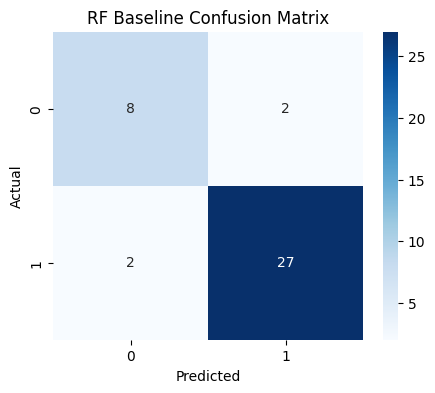

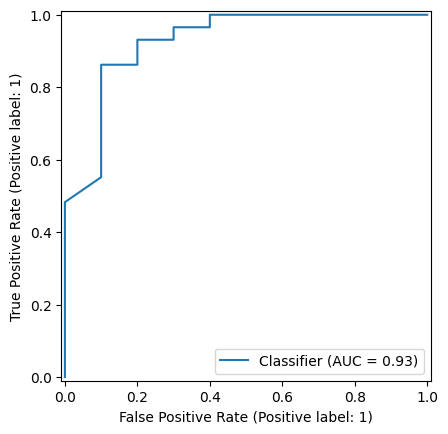

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("RF Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC
if hasattr(rf, "predict_proba"):
    RocCurveDisplay.from_predictions(y_test, probs)
    plt.show()


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

pipe_rf = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])

param_dist = {
    'clf__n_estimators': [50, 100, 200, 400],
    'clf__max_depth': [None, 8, 12, 16, 24],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2', None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=20, cv=cv,
                        scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)

# Fit on selected-feature training data
rs.fit(X_train_sel, y_train)

print("Best CV ROC AUC:", rs.best_score_)
print("Best params:", rs.best_params_)
best_model = rs.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV ROC AUC: 0.938574016563147
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 24}


In [10]:
opt_pred = best_model.predict(X_test_sel)
opt_probs = best_model.predict_proba(X_test_sel)[:,1]

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print("Optimized RF Test Accuracy:", accuracy_score(y_test, opt_pred))
print("Optimized RF Test ROC AUC:", roc_auc_score(y_test, opt_probs))
print(classification_report(y_test, opt_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, opt_pred))


Optimized RF Test Accuracy: 0.8974358974358975
Optimized RF Test ROC AUC: 0.9275862068965517
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39

Confusion Matrix:
 [[ 8  2]
 [ 2 27]]


PPE                 0.229413
spread1             0.185120
MDVP:APQ            0.104283
MDVP:Flo(Hz)        0.095374
D2                  0.093220
Shimmer:APQ5        0.066871
spread2             0.061663
MDVP:Shimmer(dB)    0.058889
MDVP:Shimmer        0.054281
HNR                 0.050886
dtype: float64

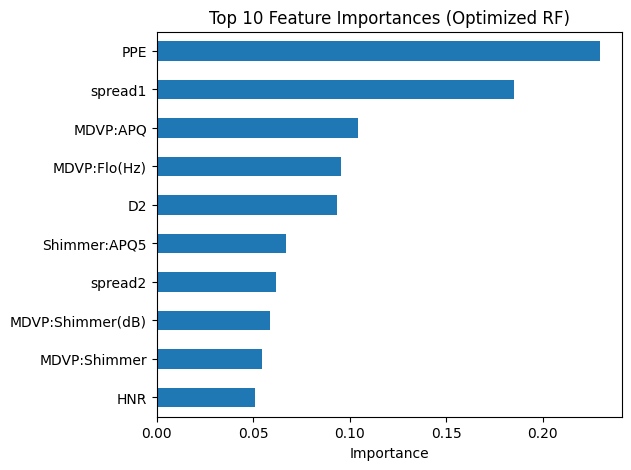

In [11]:
# extract RF from pipeline
rf_clf = best_model.named_steps['clf']
importances = rf_clf.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
display(feat_imp.head(10))

# plot top importances
plt.figure(figsize=(6,5))
feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Optimized RF)")
plt.xlabel("Importance")
plt.show()


In [12]:
import joblib, json, os
os.makedirs("../code", exist_ok=True)

model_path = "../code/rf_parkinsons_v1.joblib"
joblib.dump(best_model, model_path)
print("Saved model to:", model_path)

feat_path = "../code/selected_features.json"
with open(feat_path, "w") as f:
    json.dump(selected_features, f)
print("Saved selected features to:", feat_path)


Saved model to: ../code/rf_parkinsons_v1.joblib
Saved selected features to: ../code/selected_features.json


In [13]:
# Verify saved files
import os

print("Code folder contents:")
print(os.listdir("../code"))


Code folder contents:
['rf_parkinsons_v1.joblib', 'selected_features.json']


In [14]:
# Load the saved model and selected features to test them
import joblib, json

model_path = "../code/rf_parkinsons_v1.joblib"
feat_path = "../code/selected_features.json"

# Load model
loaded_model = joblib.load(model_path)

# Load selected features
with open(feat_path, "r") as f:
    loaded_features = json.load(f)

print("Model and features loaded successfully!")
print("Loaded features:", loaded_features)


Model and features loaded successfully!
Loaded features: ['MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'HNR', 'spread1', 'spread2', 'D2', 'PPE']


In [15]:
# Pick one sample from the test data
sample = X_test[loaded_features].iloc[0].values.reshape(1, -1)

# Predict using the loaded model
prediction = loaded_model.predict(sample)[0]

# Interpret result
if prediction == 1:
    print("🩺 Predicted: Parkinson’s Disease detected.")
else:
    print("✅ Predicted: Healthy (no Parkinson’s detected).")


🩺 Predicted: Parkinson’s Disease detected.


C:\Users\Madhusree J\Desktop\internship_project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
# Create a small CSV file (3 rows) for testing in Streamlit app
import pandas as pd
import os

os.makedirs("../app", exist_ok=True)
sample_data = X_test[loaded_features].head(3)
sample_path = "../app/sample_upload.csv"

sample_data.to_csv(sample_path, index=False)
print("Sample input CSV created at:", sample_path)
display(sample_data)


Sample input CSV created at: ../app/sample_upload.csv


,MDVP:Flo(Hz),MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ5,MDVP:APQ,HNR,spread1,spread2,D2,PPE
185,96.983,0.01564,0.136,0.00990,0.01691,24.199,-5.592584,0.133917,2.058658,0.214346
77,106.821,0.02199,0.197,0.01199,0.01636,25.820,-5.391029,0.250572,1.777901,0.232744
76,106.981,0.03999,0.350,0.02231,0.02704,23.370,-5.775966,0.341169,2.007923,0.193918


In [17]:
test_df = X_test[loaded_features].head(10)
preds = loaded_model.predict(test_df)

for i, val in enumerate(preds):
    print(f"Row {i+1}: {'Parkinson’s' if val==1 else 'Healthy'}")


Row 1: Parkinson’s
Row 2: Parkinson’s
Row 3: Parkinson’s
Row 4: Parkinson’s
Row 5: Healthy
Row 6: Parkinson’s
Row 7: Parkinson’s
Row 8: Parkinson’s
Row 9: Healthy
Row 10: Parkinson’s
